In [155]:
import numpy as np
import torch
import os
import glob
from pathlib import Path
from scipy.io import loadmat
from typing import Pattern, List , Union
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [156]:
DATASET = 'UTD_MAAD'
ROOT_DIR = "/home/bgu9/Fall_Detection_KD_Multimodal"
PATTERN = r'a\d+'
LABEL_PATTERN = r'\d+'

In [157]:
def create_label(pattern : Pattern, label_pattern : Pattern, path_list : List[str]) -> int:
    '''
    Function to create label for file path

    Arguements: 
        pattern : patterns to find in path 
        label_pattern : label pattern
        path : file path

    Output:
        Label 

    '''
    labels = []
    for path in path_list: 
        prog = re.compile(pattern)
        result = prog.findall(path)[0]
        act_prog =re.compile(label_pattern)
        label = int(act_prog.findall(result)[0])
        labels.append(label)
    return labels

In [158]:

def resample_data(old_rate: int , new_rate: int, dataset: List[np.ndarray]) ->  List[np.ndarray]:
    '''
    Function to change sampling rate of the data
    Arguements: 
        old_rate : exisiting sampling rate
        new_rate : new sampling rate
        data : data to resample
    Output: 
        interpolated data : data resampled to new sampling rate
    ''' 
    
     # Generate the time array based on sampling rate
    resampled_dataset = []
    for data in dataset:
        time = np.arange(0, data.shape[0]) / old_rate

        # Create interpolation functions for each dimension
        interp_functions = [interp1d(time, data[:, i], kind='linear') for i in range(data.shape[-1])]

        # Define new time array for interpolated data
        new_length = int(data.shape[0]*(new_rate/old_rate))
        new_time = np.arange(0, new_length)/ new_rate # Assuming you want to interpolate at 100Hz

        # Interpolate data for each dimension using the interpolation functions
        interpolated_data = np.column_stack([f(new_time) for f in interp_functions])
        resampled_dataset.append(interpolated_data)

    return resampled_dataset

In [159]:
def load_file(path_list: List[str], **kwargs):
    '''
    Function to load files with different extension

    Arguement: 
        path: path to load
    '''
    dataset = []
    for path in path_list:
        _, file_extension = os.path.splitext(path)

        if file_extension == '.npy':
            data = np.load(path)

        else: 
            assert 'key' in kwargs.keys() , f"File is {file_extension} type, need to provide the key "
            data  =  loadmat(path)[kwargs['key']]
        dataset.append(data)
    return dataset

In [160]:
# ploting normalitiy
def find_all_path(pattern : Pattern, paths : List[str]) -> List[str] :
    '''
        Function to find files specific to an activity

        Arguement:
            pattern : pattern related to the activity
            paths: List of paths

        Output : List of activity paths
    ''' 

    activity_path = [path for path in paths if re.findall(pattern=pattern, string=path)]
    return activity_path

# find all files of the same activity 
# def find_all(p)

In [161]:
def merge_data(activity_path : List[str], axis = None, **kwargs):
    '''
        Funciton to merge all data in one array 
        Arguements: 
            
    '''
    arrays = load_file(activity_path, **kwargs)
    concatenated_array = np.concatenate(arrays, axis = axis)
    return concatenated_array


In [162]:
def axis_plot(data: np.ndarray, axis : int = None , num_col : int = 4 ) : 
    '''
    
    '''
    plt.figure(figsize=(24, 24))
    axis_len = data.shape[axis]
    num_row = (axis_len // num_col ) + 1
    for i in range(axis_len) :
        plt.subplot(num_row, num_col, i+1)
        color = plt.cm.viridis(i / data.shape[axis])
        plt.hist(data[:, i], bins = 30, alpha = 0.5, label = f'Axis {i + 1}', color = color)
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.title('Distribution along axis {}'.format(i+1))
        plt.grid()
        plt.legend()

In [163]:
def get_pathlist(root_dir:str = "/home/bgu9/Fall_Detection_KD_Multimodal", dataset:str = 'UTD_MAAD', modality :str = 'inertial') ->  List[str]: 
    '''
    Function to get all files of a modality
    Arguement: 
        root_dir : Root directory 
        dataset :  dataset 
        modality: inertial or skeleotn
    
    Output: list of file path of specific modality
    '''

    return glob.glob(f'{root_dir}/data/{dataset}/{modality}/*')

In [164]:
def sliding_window(data, clearing_time_index, max_time, sub_window_size, stride_size):

    assert clearing_time_index >= sub_window_size - 1 , "Clearing value needs to be greater or equal to (window size - 1)"
    start = clearing_time_index - sub_window_size + 1 

    if max_time >= data.shape[0]-sub_window_size:
        max_time = max_time - sub_window_size + 1
        # 2510 // 100 - 1 25 #25999 1000 24000 = 24900

    sub_windows  = (
        start + 
        np.expand_dims(np.arange(sub_window_size), 0) + 
        np.expand_dims(np.arange(max_time, step = stride_size), 0).T
    )

    #labels = np.round(np.mean(labels[sub_windows], axis=1))
    return data[sub_windows] 



In [165]:
def process_data(dataset, window_size, stride):
    # dataframe = pd.read_csv(file_path)
    # raw_data = dataframe[['w_accelerometer_x', 'w_accelerometer_y', 'w_accelerometer_z']].to_numpy()
    # labels = dataframe['outcome'].to_numpy()
    window_set = []
    for data in dataset: 
        processed_window = sliding_window(data, window_size - 1,data.shape[0],window_size,stride)
        window_set.append(processed_window)
    return window_set


In [167]:
def create_win_label(win_list:List[np.ndarray], label_list:List[int]) -> List[np.ndarray]: 
    win_label = []
    for (data , label) in zip(win_list, label_list): 
        total_win = data.shape[0]
        win_label.append(np.repeat(label, total_win))
    return win_label

        

In [169]:
# load inertial file
DATASET = 'UTD_MAAD'
ROOT_DIR = "/home/bgu9/Fall_Detection_KD_Multimodal"
PATTERN = r'a\d+'
LABEL_PATTERN = r'\d+'

def create_dataset(name : str, root_dir : str, )
inertial_scaler = StandardScaler()

# get all inertial path 
inertial_path_list = get_pathlist()
print(len(inertial_path_list))

# load data 
inertial_set = load_file(inertial_path_list, key = 'd_iner')
resampled_data = resample_data(old_rate=50, new_rate=30, dataset = inertial_set)
#resample dataset 
window_set = process_data(dataset=resampled_data, window_size=32, stride = 16)
file_label = create_label(pattern=PATTERN, label_pattern=LABEL_PATTERN, path_list= inertial_path_list)
label_set = create_win_label(window_set, file_label)

return window_set, label_set

#

#get all skeleton path
# skeleton_path = get_pathlist(modality = 'skeleton')
# norm_iner = inertial_scaler.fit_transform(resampled_data)



861


In [121]:
# load skeleton file
modality = 'skeleton'


skeleton_op_len = {}
skeleton_len = {}

for skeleton_path in skeleton_list:
    skeleton_data = loadmat(skeleton_path)['d_skel']
    label = create_label(pattern, label_pattern, skeleton_path)

    if label not in skeleton_len: 
        skeleton_len[label] =  []
    #print("Activity: {}  Length: {}".format(label, skeleton_data.shape[2]))
    skeleton_len[label].append(skeleton_data.shape[2])
skeleton_len = dict(sorted(skeleton_len.items()))

#print("------------ Openpose ---------------")
for skeleton_path_op in skeleton_op_list:
    skeleton_data_op = np.load(skeleton_path_op)
    label_op = create_label(pattern, label_pattern, skeleton_path_op)
    if label_op not in skeleton_op_len:
        skeleton_op_len[label_op] = []
    skeleton_op_len[label_op].append(skeleton_data_op.shape[0])
skeleton_op_len = dict(sorted(skeleton_op_len.items()))
    #print("Activity: {}  Length: {}".format(label, skeleton_data_op.shape[0]))
# reshaped_data = skeleton_data.reshape((skeleton_data.shape[2], -1))[: , 33]
# reshaped_data = reshaped_data[: , np.newaxis]

# skeleton_scaler = MinMaxScaler()

# norm_skel = skeleton_scaler.fit_transform(reshaped_data)

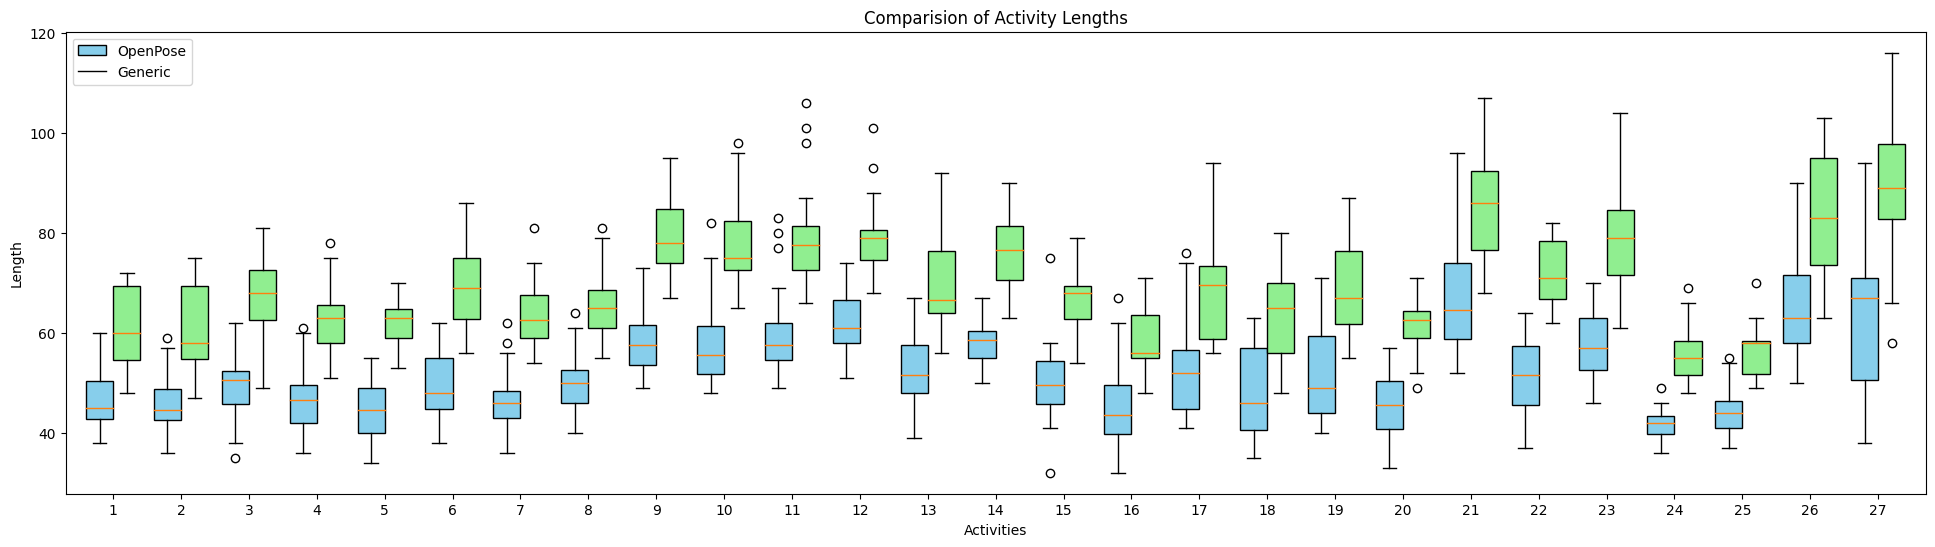

In [8]:
import matplotlib.pyplot as plt

# Define the dictionaries

# Combine values for identical keys into separate lists
data1 = [skeleton_op_len[key] for key in skeleton_op_len]
data2 = [skeleton_len[key] for key in skeleton_len]

# Create a list of keys
keys = list(skeleton_op_len.keys())

# Create boxplot
plt.figure(figsize = (24, 6))
plt.boxplot(data1, positions=[i-0.2 for i in range(1, len(keys)+1)], widths=0.4, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.boxplot(data2, positions=[i+0.2 for i in range(1, len(keys)+1)], widths=0.4, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.xticks(range(1, len(keys)+1), keys)
plt.xlabel('Activities')
plt.ylabel('Length')
plt.title('Comparision of Activity Lengths')
plt.legend(['OpenPose', 'Generic'])
plt.show()


In [101]:
act_path_skel = find_all_path(r'a17', skeleton_list)
act_path_op = find_all_path(r'a17', skeleton_op_list)

In [ ]:
def distribution_comparision(data)

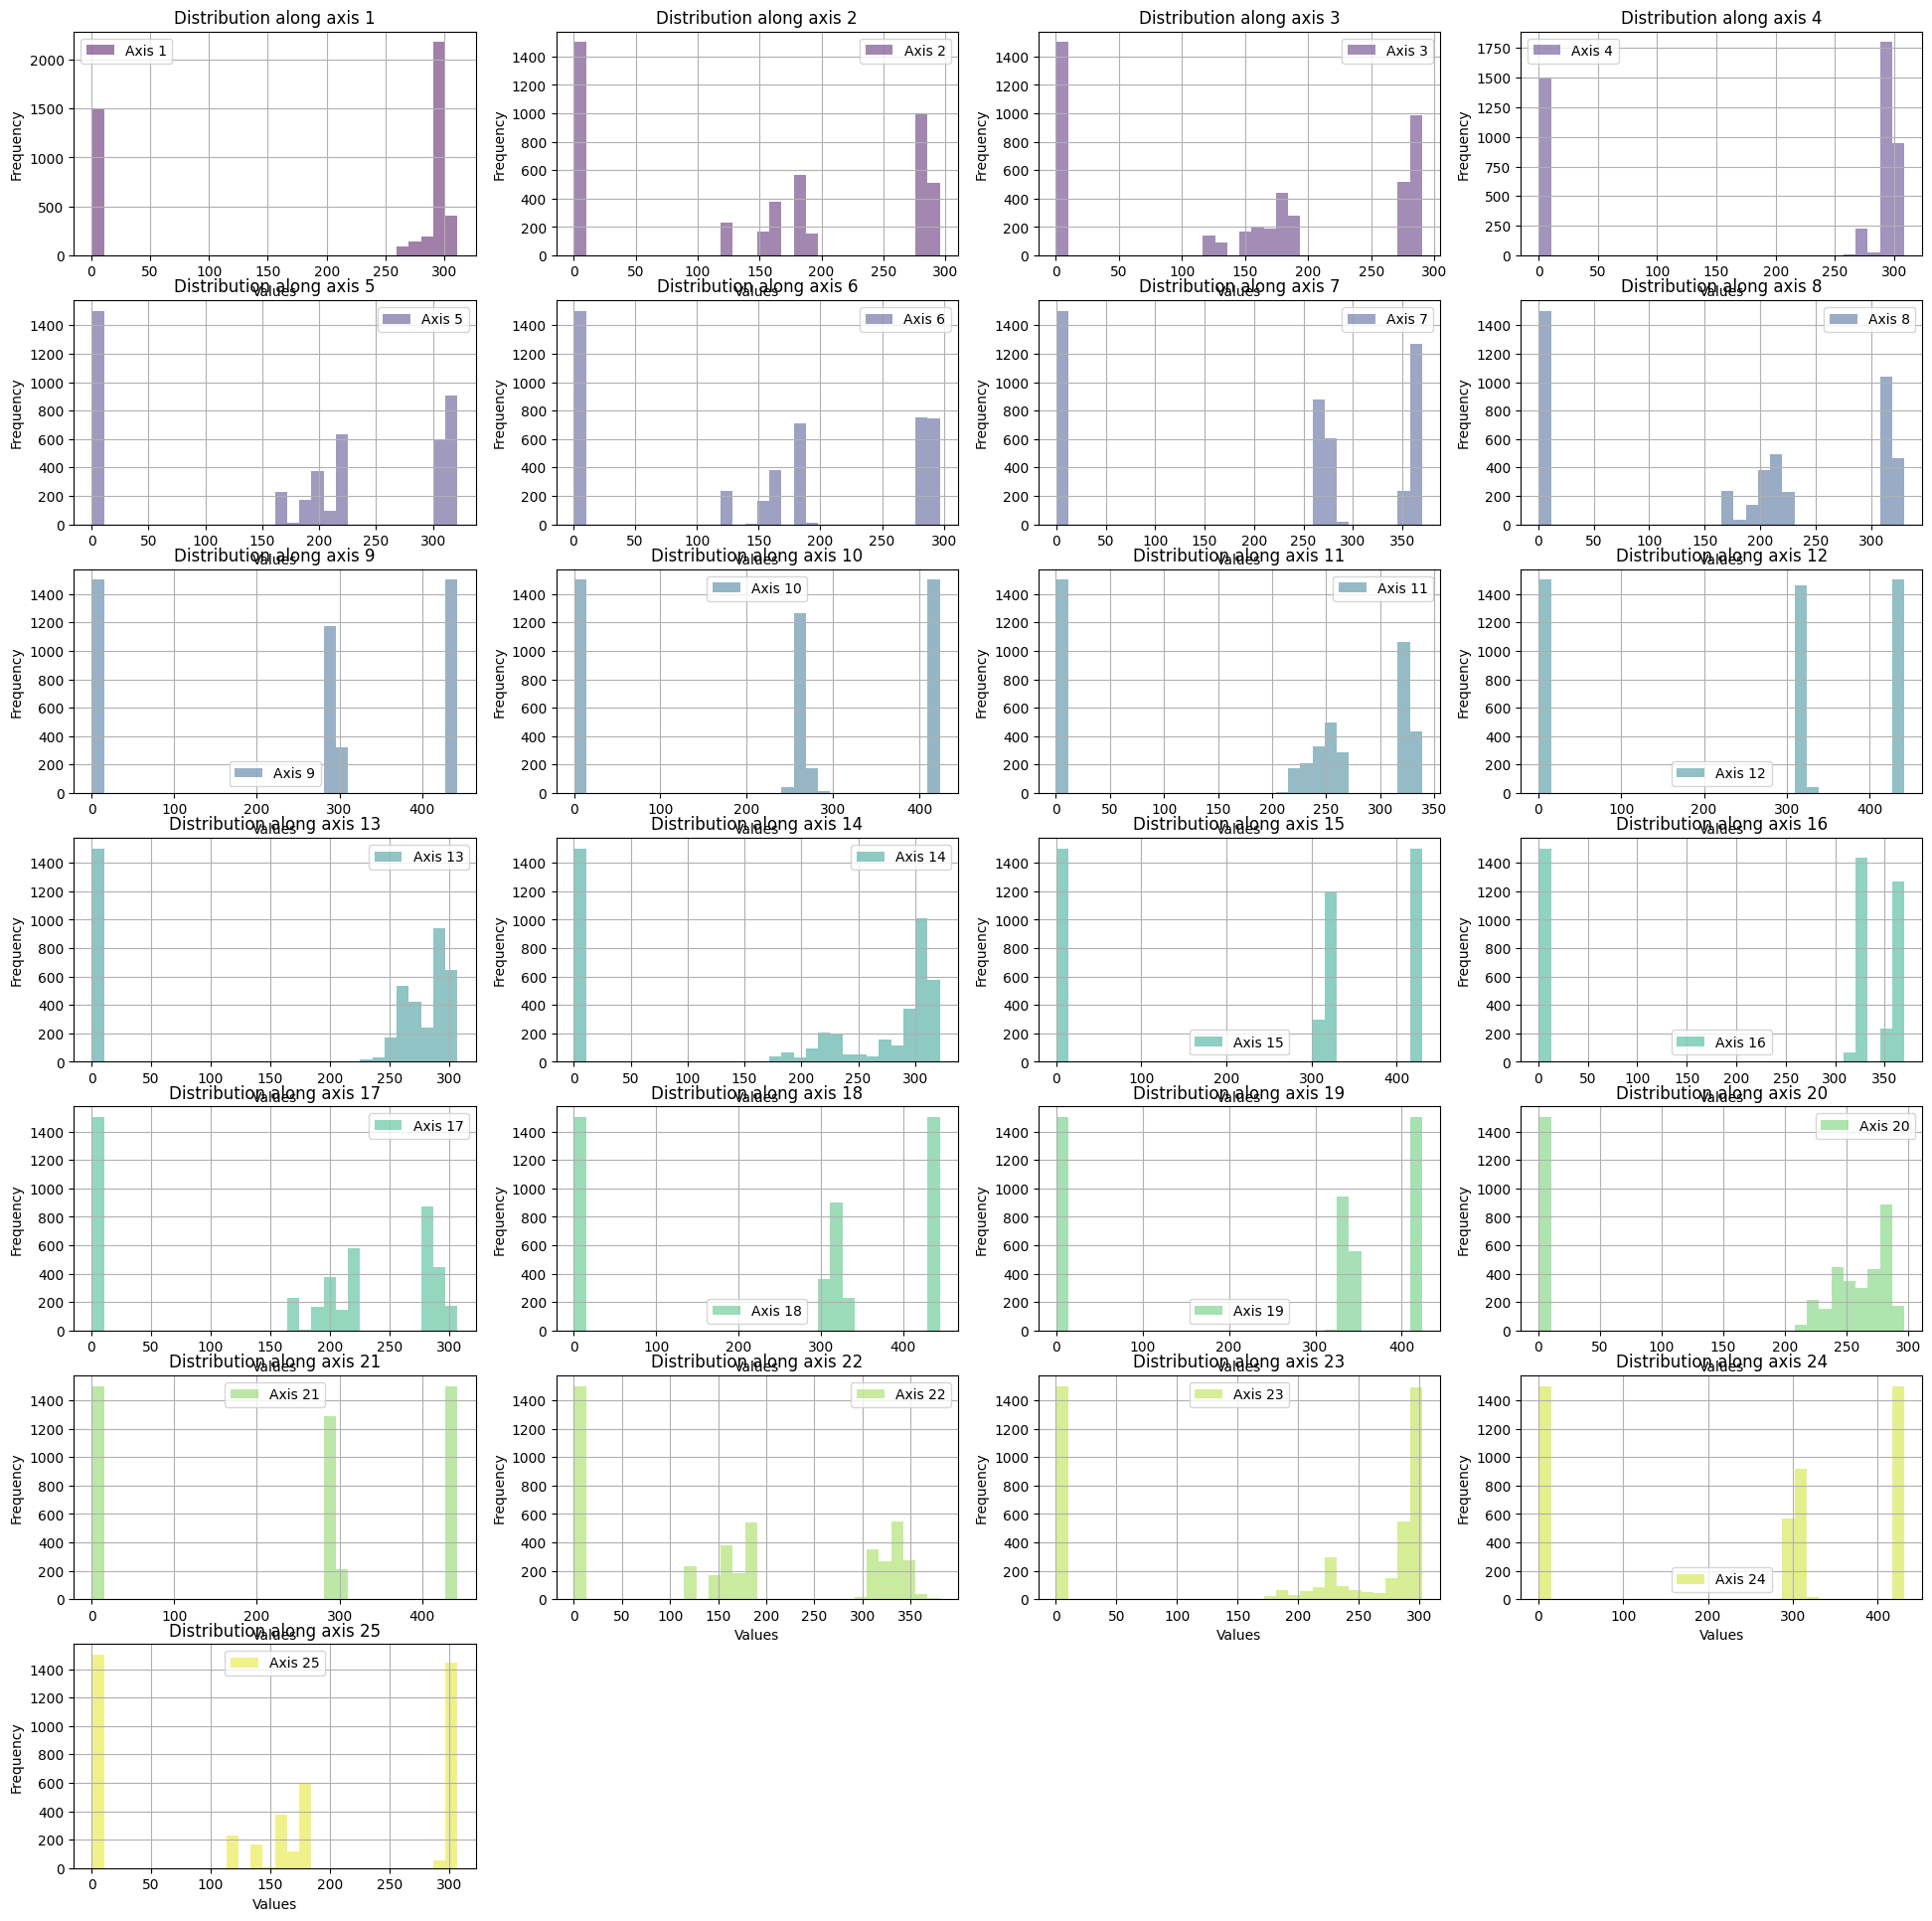

In [112]:
act_path_skel = find_all_path(r'a3', skeleton_list)
act_path_op = find_all_path(r'a4', skeleton_op_list)
merged_skel = merge_data(act_path_skel, axis = 2, key = 'd_skel').reshape((-1, 20))
merged_op = merge_data(act_path_op, axis = 0). reshape((-1, 25))
axis_plot(merged_op, axis = 1)
#axis_plot(merged_skel, axis = 1)
plt.show()

In [48]:
## load data 
inertial_data = 

(0.20803, 0.718701, 0.472873, 1.0)